# prepare data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import warnings

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

# processed data from the source below
# "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
data_path = "dataset_grouped_by_date.csv"

df = pd.read_csv(data_path)

df.rename(columns={'total_price': 'daily_sale'}, inplace=True)
df = df[['date', 'daily_sale']]

print(f'The first 7 rows (of {len(df)} rows) are:')
df.head(7)

The first 7 rows (of 305 rows) are:


,date,daily_sale
0,2010-12-01,46192.49
1,2010-12-02,47197.57
2,2010-12-03,23876.63
3,2010-12-05,31361.28
4,2010-12-06,31009.33
5,2010-12-07,53730.96
6,2010-12-08,39094.20


Text(0.5, 0.98, 'Daily sales before removing outliers')

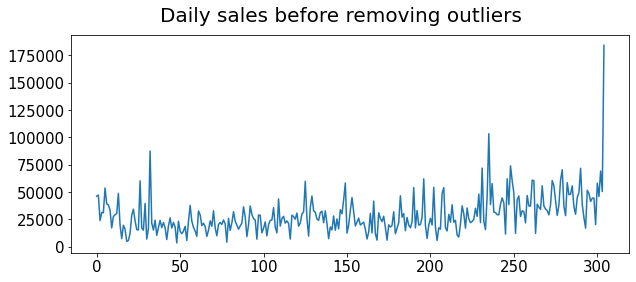

In [2]:
fig = plt.figure()
df.daily_sale.plot(figsize=(10,4), fontsize=15)
fig.suptitle('Daily sales before removing outliers', fontsize=20)

In [3]:
df = df[df.daily_sale < df.daily_sale.quantile(0.99)]

Text(0.5, 0.98, 'Daily sales after removing outliers')

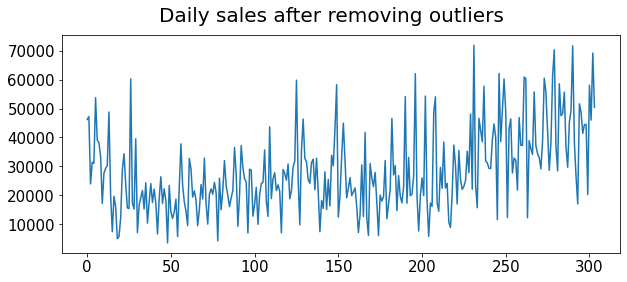

In [4]:
fig = plt.figure()
df.daily_sale.plot(figsize=(10,4), fontsize=15)
fig.suptitle('Daily sales after removing outliers', fontsize=20)

Text(0.5, 0.98, 'Daily sales of first 7 days')

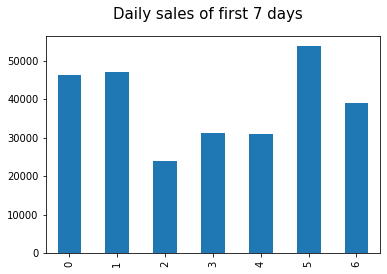

In [5]:
fig = plt.figure()
df.daily_sale.iloc[:7].plot.bar()
fig.suptitle('Daily sales of first 7 days', fontsize=15)

In [6]:
train_df = df[df.date < '2011-10-01']
test_df = df[df.date > '2011-11-01']

print(f'The first 3 rows (of {len(train_df)} rows) in Train Data are: \n')
print(train_df.head(3), '\n \n \n')

print(f'The first 3 rows (of {len(test_df)} rows) in Test Data are: \n')
print(test_df.head(3))

The first 3 rows (of 243 rows) in Train Data are: 

         date  daily_sale
0  2010-12-01    46192.49
1  2010-12-02    47197.57
2  2010-12-03    23876.63 
 
 

The first 3 rows (of 32 rows) in Test Data are: 

           date  daily_sale
272  2011-11-02    38536.44
273  2011-11-03    60536.09
274  2011-11-04    55716.47


In [7]:
# normalize data

scaler = MinMaxScaler(feature_range=(0, 1))
train_df['daily_sale'] = scaler.fit_transform(train_df.daily_sale.values.reshape(-1, 1))
test_df['daily_sale'] = scaler.transform(test_df.daily_sale.values.reshape(-1, 1))

Text(0.5, 0.98, 'Daily sales of first 7 days (Normalized)')

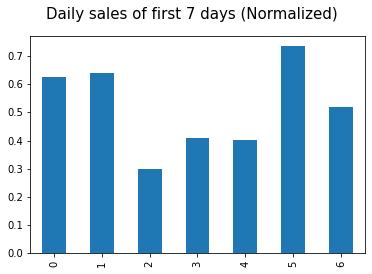

In [8]:
fig = plt.figure()
train_df.daily_sale.iloc[:7].plot.bar()
fig.suptitle('Daily sales of first 7 days (Normalized)', fontsize=15)

# create single-feature dataset

In [9]:
# source: machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=6):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        this_chunk = dataset[i:(i+look_back)]
        dataX.append(this_chunk)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [10]:
trainX, trainY = create_dataset(train_df.daily_sale.values)
testX, testY = create_dataset(test_df.daily_sale.values)


In [11]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [12]:
# create and fit the LSTM network

def build_model(input_shape=(None, 1)):
    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape, dropout=0.1))
    model.add(Dense(8))
    model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate=5e-5)
    model.compile(loss='mean_squared_error', optimizer=opt)

    print(model.summary())

    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 4,625
Trainable params: 4,625
Non-trainable params: 0
_________________________________________________________________
None


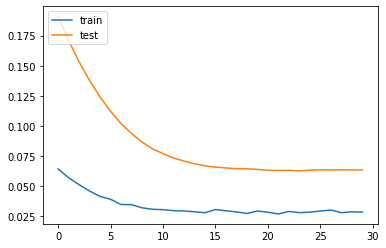

In [13]:
model = build_model()
history = model.fit(trainX, trainY, epochs=30, batch_size=16, verbose=0, validation_data=(testX, testY))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

In [14]:
trainPredict = model.predict(trainX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

<BarContainer object of 20 artists>

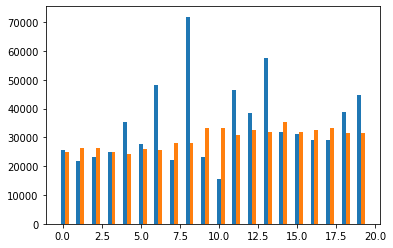

In [15]:
x = np.arange(20)
plt.bar(x, trainY.reshape(-1)[-20:],  width = 0.25)
plt.bar(x+0.25, trainPredict.reshape(-1)[-20:],  width = 0.25)

In [16]:
testPredict = model.predict(testX)
# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

<BarContainer object of 20 artists>

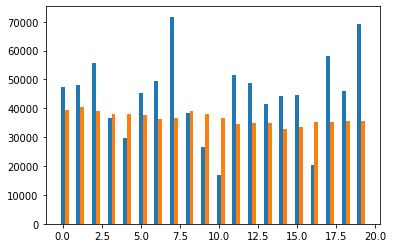

In [17]:
x = np.arange(20)
plt.bar(x, testY.reshape(-1)[-20:],  width = 0.25)
plt.bar(x+0.25, testPredict.reshape(-1)[-20:],  width = 0.25)